In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

import autokeras as ak

os.chdir("/home/pchabets/Dropbox/STRESS_INDEX/")

<IPython.core.display.Javascript object>

In [2]:
#proteomics
prtm = pd.read_csv("data/blood_and_saliva_variables/W1/proteomics/output/proteomics_replaced_outliers.csv")
prtm = prtm.drop('applate', axis=1)

In [3]:
#label data
y = pd.read_spss("data/outcome_groups/DSM_groups.sav", convert_categoricals=True)
y = y.drop('Remitted_comorbid', axis=1)
y = y.rename(columns={'pident':'Pident'})
y['Pident'] = y['Pident'].astype(int)

In [4]:
whole_set = pd.merge(y, prtm, how='inner', on='Pident')

In [5]:
whole_set

,Pident,Remitted_depression,ap6Ckine,apAPN,apAgRP,apAldRed,apAACT,apAAT,apA1Micr,apA1Macr,...,apVEGFC,apVEGFD,apVEGFR1,apVEGFR2,apVEGFR3,apVDBP,apVKDPS,apVN,apVWF,apYKL40
0,100012,non-remitted,325,1.6,113,14.0,713,2.2,11.0,2.5,...,36.0,433.0,455,11.0,76.0,419.0,16.0,2380,93.0,32.0
1,100047,remitted,508,4.5,113,8.2,581,1.1,9.5,1.5,...,30.0,433.0,455,7.6,15.0,107.0,13.0,1300,31.0,17.0
2,100053,remitted,548,3.9,113,12.0,768,1.9,5.3,1.5,...,NaN,NaN,455,8.4,64.0,410.0,19.0,1510,54.0,28.0
3,100068,non-remitted,547,6.1,113,13.0,982,2.1,17.0,1.7,...,41.0,433.0,455,6.7,48.0,273.0,17.0,2150,30.0,108.0
4,100084,non-remitted,430,3.3,113,14.0,768,1.4,12.0,1.7,...,45.0,433.0,455,7.9,50.0,274.0,19.0,2010,43.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,330160,remitted,822,3.6,113,5.8,561,1.4,6.8,1.8,...,35.0,433.0,455,4.6,29.0,190.0,11.0,1840,42.0,20.0
607,330171,remitted,435,5.1,113,11.0,947,2.2,8.8,1.9,...,45.0,433.0,455,8.7,29.0,244.0,14.0,2340,35.0,21.0
608,330221,remitted,673,3.4,113,9.1,663,1.9,12.0,1.9,...,31.0,433.0,455,5.9,33.0,251.0,16.0,1830,39.0,17.0
609,330284,remitted,675,6.6,113,5.2,666,1.4,10.0,1.5,...,49.0,565.0,455,6.6,39.0,137.0,16.0,2300,26.0,42.0


In [6]:
#Turn labels into 0's and 1's: non-remitted = 0, remitted = 1
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder() 
whole_set['Remitted_depression'] = lbl.fit_transform(whole_set['Remitted_depression']) 

In [7]:
X = whole_set.drop(['Pident','Remitted_depression'], axis=1)
y = whole_set.pop('Remitted_depression')

### log10 transform data, can be done before train/test split because pointwise operation

In [8]:
X = np.log10(X) 

### Train-test split (80-20)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, shuffle=True)

### Preprocessing: remove zero-variance variables and impute NaN's with median

In [10]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

#### Select ZV columns from trainings data and remove them from train + test X

In [11]:
selector = VarianceThreshold()
selector.fit(X_train)

VarianceThreshold()

In [12]:
X_names = list(X_train.columns[selector.get_support()])

In [13]:
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

In [14]:
print(str(X.shape[1]-X_train.shape[1]) + " analytes with zero variance")

5 analytes with zero variance


#### Calculate median for each column in train X, and replace NaNs with that value in both train and test X

In [15]:
imputer = SimpleImputer(strategy="median")

In [16]:
imputer.fit(X_train)

SimpleImputer(strategy='median')

In [17]:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

#### Scale data with MinMax scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

In [20]:
scaler.fit(X_train)

MinMaxScaler()

In [21]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Convert back to dataframe
X_train = pd.DataFrame(data=X_train,columns=X_names) 
X_test = pd.DataFrame(data=X_test, columns=X_names)

## Creating the model

In [23]:
clf = ak.StructuredDataClassifier(overwrite=False, 
                                  max_trials=100, 
                                  objective='val_accuracy',
                                  directory="/Users/philippehabets/Dropbox/STRESS_INDEX/scripts/Predictions_explorative/Python.scripts/output"
                                 )

In [24]:
# Feed the structured data classifier with training data.
clf.fit(X_train, y_train, 
#         epochs=10, 
        validation_split=0.3)

Trial 50 Complete [00h 00m 08s]
val_accuracy: 0.6442307829856873

Best val_accuracy So Far: 0.7307692170143127
Total elapsed time: 00h 08m 18s
INFO:tensorflow:Oracle triggered exit
Epoch 1/7
16/16 [==============================] - 2s 5ms/step - loss: 1.2774 - accuracy: 0.5033
Epoch 2/7
16/16 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.6815
Epoch 3/7
16/16 [==============================] - 0s 5ms/step - loss: 0.4812 - accuracy: 0.7677
Epoch 4/7
16/16 [==============================] - 0s 5ms/step - loss: 0.2695 - accuracy: 0.8887
Epoch 5/7
16/16 [==============================] - 0s 5ms/step - loss: 0.2158 - accuracy: 0.9170
Epoch 6/7
16/16 [==============================] - 0s 6ms/step - loss: 0.1146 - accuracy: 0.9725
Epoch 7/7
16/16 [==============================] - 0s 6ms/step - loss: 0.1147 - accuracy: 0.9524
INFO:tensorflow:Assets written to: /Users/philippehabets/Dropbox/STRESS_INDEX/scripts/Predictions_explorative/Python.scripts/output/structur

In [68]:
# model = clf.export_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 232)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 232)               0         
_________________________________________________________________
normalization (Normalization (None, 232)               465       
_________________________________________________________________
dense (Dense)                (None, 512)               119296    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [69]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 232)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 232)               0         
_________________________________________________________________
normalization (Normalization (None, 232)               465       
_________________________________________________________________
dense (Dense)                (None, 512)               119296    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

## Model evaluation

In [76]:
# Predict with the best model.
predicted_y = clf.predict(X_test)

In [27]:
# Evaluate the best model with testing data.
clf.evaluate(X_train, y_train)

16/16 [==============================] - 1s 3ms/step - loss: 0.1993 - accuracy: 0.9447


[0.19931243360042572, 0.9446721076965332]

In [28]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 3ms/step - loss: 1.8562 - accuracy: 0.6423


[1.8561910390853882, 0.642276406288147]

In [75]:
predicted_y

array([[6.73949216e-06],
       [7.18849242e-01],
       [2.96720648e-09],
       [8.66177440e-01],
       [8.41271176e-05],
       [1.35878486e-06],
       [9.38352332e-06],
       [4.30389702e-01],
       [3.45959067e-02],
       [9.62552011e-01],
       [9.02306318e-01],
       [1.76414847e-03],
       [9.99806881e-01],
       [9.87033367e-01],
       [4.06758189e-02],
       [9.93640542e-01],
       [9.21021819e-01],
       [8.64747167e-02],
       [9.94938970e-01],
       [5.61152956e-05],
       [6.60984159e-01],
       [5.36158979e-01],
       [2.16290057e-02],
       [3.88450325e-02],
       [6.43470557e-05],
       [3.87523472e-01],
       [1.58619493e-01],
       [1.47712826e-05],
       [6.06524944e-03],
       [2.36023361e-08],
       [2.88781524e-02],
       [3.54826450e-04],
       [3.41783583e-01],
       [5.31236231e-02],
       [1.12752495e-07],
       [6.37558756e-11],
       [6.82643414e-01],
       [7.66448975e-01],
       [8.51165116e-01],
       [9.99092817e-01],


In [30]:
from sklearn.metrics import classification_report,confusion_matrix

In [31]:
print(classification_report(y_test,y_pred=predicted_y))
print(confusion_matrix(y_test,predicted_y, normalize="true"))

              precision    recall  f1-score   support

           0       0.64      0.74      0.69        66
           1       0.64      0.53      0.58        57

    accuracy                           0.64       123
   macro avg       0.64      0.63      0.63       123
weighted avg       0.64      0.64      0.64       123

[[0.74242424 0.25757576]
 [0.47368421 0.52631579]]


### Save model 

In [34]:
# try:
#     model.save("/scripts/VM/Python/output/model_autokeras", save_format="tf")
# except Exception:
#     model.save("/scripts/VM/Python/output/model_autokeras.h5")

INFO:tensorflow:Assets written to: scripts/Predictions_explorative/Python.scripts/output/model_autokeras/assets


### Load model for further plotting/analysis

In [37]:
loaded_model = tf.keras.models.load_model("scripts/VM/Python/output/model_autokeras", 
                                          custom_objects=ak.CUSTOM_OBJECTS
                                         )

In [41]:
loaded_model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 1.8562 - accuracy: 0.6423


[1.8561910390853882, 0.642276406288147]

### Plot ROC curve and calculate AUC

In [70]:
from sklearn.metrics import plot_roc_curve, roc_curve, auc, plot_confusion_matrix

In [61]:
y_pred_keras = loaded_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

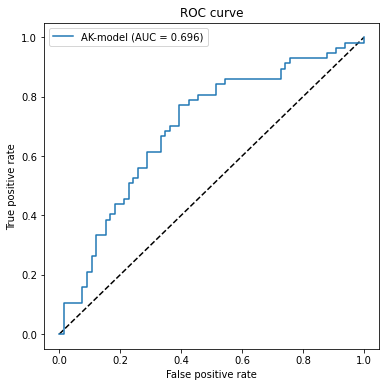

In [67]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AK-model (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Plot confusion matrix

In [111]:
cm = confusion_matrix(y_test, predicted_y, normalize="pred", labels=[0, 1])

In [112]:
#non-remitted = 0, remitted = 1
pd.DataFrame(cm)

,0,1
0,0.644737,0.361702
1,0.355263,0.638298


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

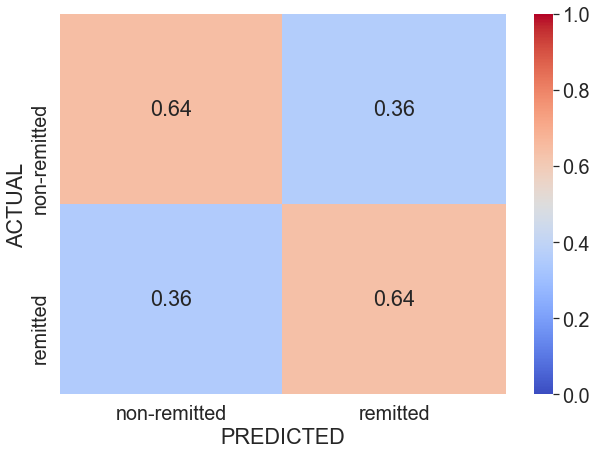

In [174]:
#Plot confusion matrix
import seaborn as sns
plt.figure(figsize = (10,7))
ax = plt.axes()
sns.heatmap(cm, 
            annot=True,
            vmin=0,
            vmax=1,
            cmap='coolwarm',
            xticklabels=['non-remitted', 'remitted'], 
            yticklabels=['non-remitted', 'remitted'])
ax.set(xlabel='PREDICTED', ylabel = 'ACTUAL')
sns.set(font_scale=1.8)

In [176]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score

print("Precision: {}".format(precision_score(y_test,predicted_y).round(2)))
print("Recall: {}".format(recall_score(y_test,predicted_y).round(2)))
print("F1 Score: {}".format(f1_score(y_test,predicted_y).round(2)))
print("Accuracy: {}".format(accuracy_score(y_test,predicted_y).round(2)))
print("Balanced accuracy: {}".format(balanced_accuracy_score(y_test,predicted_y).round(2)))

Precision: 0.64
Recall: 0.53
F1 Score: 0.58
Accuracy: 0.64
Balanced accuracy: 0.63
